In [1]:
# --------------------- 1. Imports ---------------------
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Dropout, Input, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Activation, Conv2D, Concatenate, Add, Multiply, Reshape, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetV2B3
import os
import cv2  # For Grad-CAM visualization

In [2]:
# --------------------- 2. Set Mixed Precision Policy ---------------------
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [3]:
# --------------------- 3. Configure GPUs for Memory Growth ---------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# --------------------- 4. Define Paths ---------------------
train_image_dir = '/kaggle/input/aptos2019/train_images/train_images'
val_image_dir = '/kaggle/input/aptos2019/val_images/val_images'
test_image_dir = '/kaggle/input/aptos2019/test_images/test_images'
train_csv = '/kaggle/input/aptos2019/train_1.csv'
val_csv = '/kaggle/input/aptos2019/valid.csv'
test_csv = '/kaggle/input/aptos2019/test.csv'

In [5]:

# --------------------- 5. Read CSV Files ---------------------
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)
print("Training Set:")
print(train_df['diagnosis'].value_counts())
print("\nValidation Set:")
print(val_df['diagnosis'].value_counts())
print("\nTest Set:")
print(test_df['diagnosis'].value_counts())

Training Set:
diagnosis
0    1434
2     808
1     300
4     234
3     154
Name: count, dtype: int64

Validation Set:
diagnosis
0    172
2    104
1     40
4     28
3     22
Name: count, dtype: int64

Test Set:
diagnosis
0    199
2     87
4     33
1     30
3     17
Name: count, dtype: int64


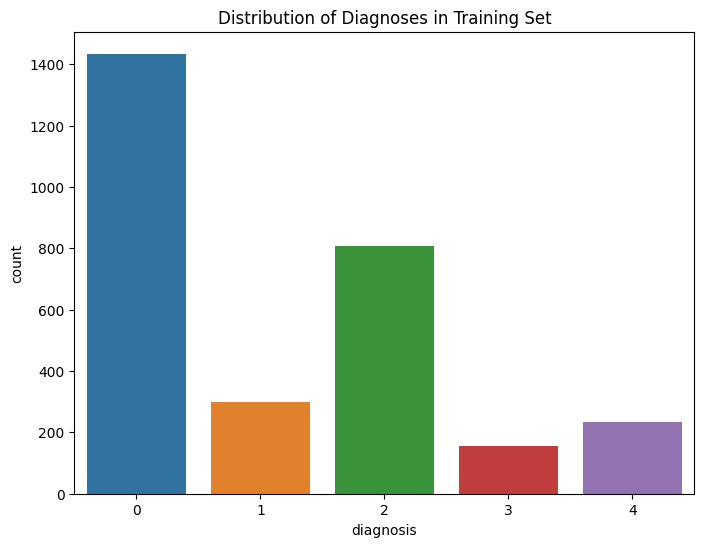

In [6]:
# --------------------- 6. Visualize Distribution of Diagnoses in Training Set ---------------------
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=train_df)
plt.title('Distribution of Diagnoses in Training Set')
plt.show()

In [7]:
# --------------------- 7. Define Constants ---------------------
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 50

AUTOTUNE = tf.data.AUTOTUNE

In [8]:
# --------------------- 8. Label Mapping: Convert to Three Classes ---------------------
def map_to_three_classes(label):
    if label == 0:
        return 0
    elif label in [1, 2]:
        return 1
    else:
        return 2

train_df['diagnosis'] = train_df['diagnosis'].apply(map_to_three_classes)
val_df['diagnosis'] = val_df['diagnosis'].apply(map_to_three_classes)
test_df['diagnosis'] = test_df['diagnosis'].apply(map_to_three_classes)

In [9]:
# --------------------- 9. Define Mixup Function ---------------------
def mixup(image, label, alpha=0.2):
    def sample_beta_distribution(size, concentration_0=alpha, concentration_1=alpha, dtype=tf.float16):
        gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1, dtype=dtype)
        gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0, dtype=dtype)
        return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

    batch_size = tf.shape(image)[0]
    lam = sample_beta_distribution(batch_size, dtype=image.dtype)
    lam_x = tf.reshape(lam, (batch_size, 1, 1, 1))
    lam_y = tf.reshape(lam, (batch_size, 1))

    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_image = tf.gather(image, indices)
    shuffled_label = tf.gather(label, indices)

    lam_x = tf.cast(lam_x, dtype=image.dtype)
    lam_y = tf.cast(lam_y, dtype=label.dtype)

    mixed_image = lam_x * image + (1 - lam_x) * shuffled_image
    mixed_label = lam_y * label + (1 - lam_y) * shuffled_label
    return mixed_image, mixed_label


In [10]:
# --------------------- 10. Data Augmentation ---------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [11]:
# --------------------- 11. Preprocessing Function ---------------------
def preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = data_augmentation(image)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    image = tf.cast(image, dtype=tf.float16)
    return image, label

In [12]:
# --------------------- 12. Create File Paths ---------------------
def create_file_paths(df, image_dir):
    df = df.copy()
    df['filepath'] = df['id_code'].apply(lambda x: os.path.join(image_dir, f"{x}.png"))
    return df

train_df = create_file_paths(train_df, train_image_dir)
val_df = create_file_paths(val_df, val_image_dir)
test_df = create_file_paths(test_df, test_image_dir)

In [13]:
# --------------------- 13. Visualize Data Augmentation ---------------------
def visualize_augmentation(df, num_samples=5):
    sample_df = df.sample(n=num_samples)
    file_paths = sample_df['filepath'].values
    labels = sample_df['diagnosis'].values

    plt.figure(figsize=(15, 6))
    for i, (file_path, label) in enumerate(zip(file_paths, labels)):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, IMAGE_SIZE)
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"Original: Class {label}")
        plt.axis('off')

        aug_image = data_augmentation(image)
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(aug_image.numpy().astype("uint8"))
        plt.title(f"Augmented: Class {label}")
        plt.axis('off')
    plt.show()
    visualize_augmentation(train_df)

In [14]:
# --------------------- 14. Create TensorFlow Datasets ---------------------
def create_tf_dataset(df, is_training=True):
    file_paths = df['filepath'].values
    labels = df['diagnosis'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)
    labels = tf.cast(labels, dtype=tf.float16)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    if is_training:
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.map(lambda x, y: mixup(x, y, alpha=0.2), num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(train_df, is_training=True)
val_dataset = create_tf_dataset(val_df, is_training=False)
test_dataset = create_tf_dataset(test_df, is_training=False)

In [15]:
# --------------------- 15. Define Focal Loss with Label Smoothing ---------------------
def focal_loss_with_label_smoothing(alpha=0.25, gamma=2.0, label_smoothing=0.1):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_true = y_true * (1 - label_smoothing) + (label_smoothing / NUM_CLASSES)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss

In [16]:
# --------------------- 16. Define SE Block ---------------------
def se_block(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]
    se_shape = (1, 1, channel)
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = Dense(channel, activation='sigmoid', kernel_initializer='he_normal')(se)
    x = Multiply()([input_tensor, se])
    return x


In [17]:
import tensorflow as tf

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class FuzzyLayer(Layer):
    def __init__(self, num_classes, input_dim, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.input_dim = input_dim

    def build(self, input_shape):
        # Define trainable weights for fuzzy membership centers and sigmas
        self.centers = self.add_weight(
            shape=(self.num_classes, self.input_dim),
            initializer='uniform',
            trainable=True,
            name='centers'
        )
        self.sigmas = self.add_weight(
            shape=(self.num_classes, self.input_dim),
            initializer=tf.keras.initializers.Constant(1.0),
            trainable=True,
            name='sigmas'
        )

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)  # Shape: (batch_size, 1, input_dim)
        centers = tf.expand_dims(self.centers, axis=0)  # Shape: (1, num_classes, input_dim)
        sigmas = tf.expand_dims(self.sigmas, axis=0)  # Shape: (1, num_classes, input_dim)

        # Ensure positive standard deviation
        sigmas = tf.nn.softplus(sigmas) + 1e-6

        # Compute Gaussian membership function
        gaussian = tf.exp(-tf.square(x - centers) / (2 * tf.square(sigmas)))
        gaussian = tf.reduce_sum(gaussian, axis=-1)  # Sum across feature dimensions
        gaussian = gaussian + tf.keras.backend.epsilon()  # Avoid log(0) issues

        return gaussian


In [19]:
# --------------------- 18. Define Explainable Attention Block ---------------------
def explainable_attention_block(input_tensor):
    """
    This block adds explainable attention mechanisms to the model.
    """
    # Compute attention scores
    attention = Conv2D(1, kernel_size=1, activation='sigmoid')(input_tensor)
    # Apply attention scores
    attended_feature_map = Multiply()([input_tensor, attention])
    return attended_feature_map, attention  # Return attention for explainability


In [20]:
# --------------------- 19. Model Definition with Explainable AI ---------------------
def create_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = True

    x = base_model.output
    x = se_block(x)

    # Channel and Spatial Attention
    # Channel Attention
    channel_avg = GlobalAveragePooling2D()(x)
    channel_max = GlobalMaxPooling2D()(x)
    shared_dense_one = Dense(x.shape[-1] // 8, activation='relu')
    shared_dense_two = Dense(x.shape[-1], activation='sigmoid')
    mlp_avg = shared_dense_one(channel_avg)
    mlp_avg = shared_dense_two(mlp_avg)
    mlp_max = shared_dense_one(channel_max)
    mlp_max = shared_dense_two(mlp_max)
    channel_attention = Add()([mlp_avg, mlp_max])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Lambda(lambda y: tf.expand_dims(tf.expand_dims(y, 1), 1))(channel_attention)
    x = Multiply()([x, channel_attention])

    # Spatial Attention
    spatial_avg = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    spatial_max = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    spatial_concat = Concatenate(axis=-1)([spatial_avg, spatial_max])
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_concat)
    x = Multiply()([x, spatial_attention])

    # Explainable Attention Block
    x, attention_scores = explainable_attention_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    fuzzy_output = FuzzyLayer(num_classes=num_classes, input_dim=256)(x)
    outputs = Activation('softmax')(fuzzy_output)
    outputs = Lambda(lambda x: tf.cast(x, dtype='float32'))(outputs)

    model = Model(inputs, outputs)

    # Create a separate model to output attention scores for explainability
    attention_model = Model(inputs, attention_scores, name='attention_model')

    return model, attention_model

model, attention_model = create_model()

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# --------------------- 20. Compile the Model ---------------------
from tensorflow.keras.optimizers import Adam

try:
    from tensorflow.keras.optimizers import AdamW
    optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
    print("Using TensorFlow's native AdamW optimizer.")
except ImportError:
    print("AdamW optimizer not found in tf.keras.optimizers. Using Adam as a fallback.")
    optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=focal_loss_with_label_smoothing(alpha=0.25, gamma=2.0, label_smoothing=0.1),
    metrics=['accuracy']
)

Using TensorFlow's native AdamW optimizer.


In [22]:
# --------------------- 21. Define Callbacks ---------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.5
    elif epoch < 30:
        return lr * 0.1
    else:
        return lr * 0.01

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

In [23]:
# --------------------- 22. Train the Model ---------------------
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_callback],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5958 - loss: 0.1107   
Epoch 1: val_loss improved from inf to 0.06290, saving model to best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.5963 - loss: 0.1106 - val_accuracy: 0.8197 - val_loss: 0.0629 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.7663 - loss: 0.0766
Epoch 2: val_loss improved from 0.06290 to 0.05643, saving model to best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 130s 705ms/step - accuracy: 0.7664 - loss: 0.0766 - val_accuracy: 0.8388 - val_loss: 0.0564 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.7808 - loss: 0.0730
Epoch 3: val_loss improved from 0.0

In [24]:
# --------------------- 23. Load the Best Model ---------------------
model.load_weights('best_model.keras')

Generating Fuzzy Predictions on Test Set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 942ms/step

--- Fuzzy Class Memberships for Sample Predictions ---
Sample 1:
  No DR: 0.8081
  Mild/Moderate DR: 0.1405
  Severe/Proliferative DR: 0.0516


Sample 2:
  No DR: 0.0793
  Mild/Moderate DR: 0.7529
  Severe/Proliferative DR: 0.1680


Sample 3:
  No DR: 0.0571
  Mild/Moderate DR: 0.1552
  Severe/Proliferative DR: 0.7876


Sample 4:
  No DR: 0.8657
  Mild/Moderate DR: 0.0912
  Severe/Proliferative DR: 0.0431


Sample 5:
  No DR: 0.8394
  Mild/Moderate DR: 0.1003
  Severe/Proliferative DR: 0.0608



ROC AUC Score: 0.9711101934471086

--- Average Class Membership Probabilities Across Test Set ---
No DR: 0.5016
Mild/Moderate DR: 0.3255
Severe/Proliferative DR: 0.1730

--- Visualizing Fuzzy Memberships ---


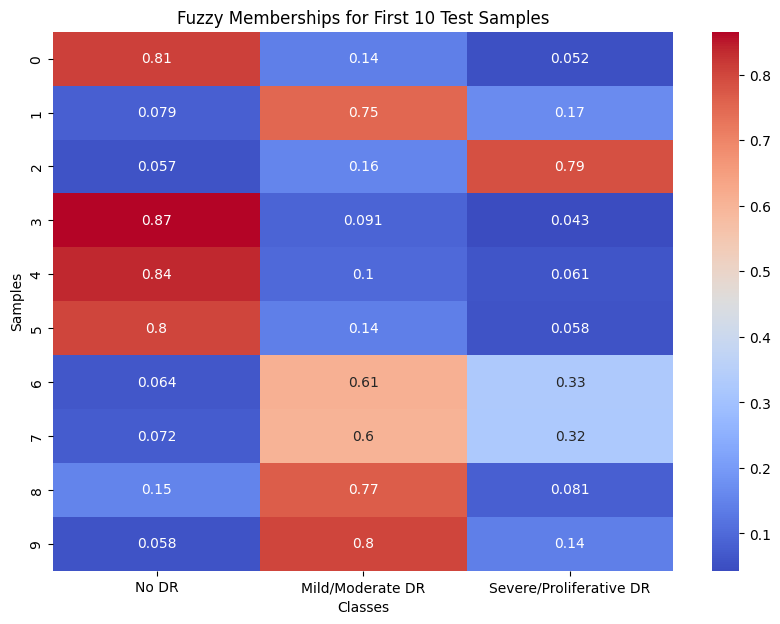

In [25]:
# --------------------- 24. Evaluation on Test Set ---------------------
print("Generating Fuzzy Predictions on Test Set...")
y_pred = model.predict(test_dataset, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_df['diagnosis'].values[:len(y_pred_classes)]

# Display Fuzzy Membership Probabilities for First 5 Samples
def display_fuzzy_memberships(y_pred, num_samples=5):
    classes = ['No DR', 'Mild/Moderate DR', 'Severe/Proliferative DR']
    print("\n--- Fuzzy Class Memberships for Sample Predictions ---")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        for cls, prob in zip(classes, y_pred[i]):
            print(f"  {cls}: {prob:.4f}")
        print("\n")

display_fuzzy_memberships(y_pred, num_samples=5)

# Compute ROC AUC Score
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=NUM_CLASSES)
roc_auc = roc_auc_score(y_true_one_hot, y_pred, multi_class='ovr')
print("\nROC AUC Score:", roc_auc)

# Compute Average Class Membership Probabilities Across Test Set
mean_probs = np.mean(y_pred, axis=0)
classes = ['No DR', 'Mild/Moderate DR', 'Severe/Proliferative DR']

print("\n--- Average Class Membership Probabilities Across Test Set ---")
for cls, prob in zip(classes, mean_probs):
    print(f"{cls}: {prob:.4f}")

# Visualize Memberships for First 10 Test Samples
print("\n--- Visualizing Fuzzy Memberships ---")
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(y_pred[:10], annot=True, cmap='coolwarm', xticklabels=classes)
plt.xlabel("Classes")
plt.ylabel("Samples")
plt.title("Fuzzy Memberships for First 10 Test Samples")
plt.show()

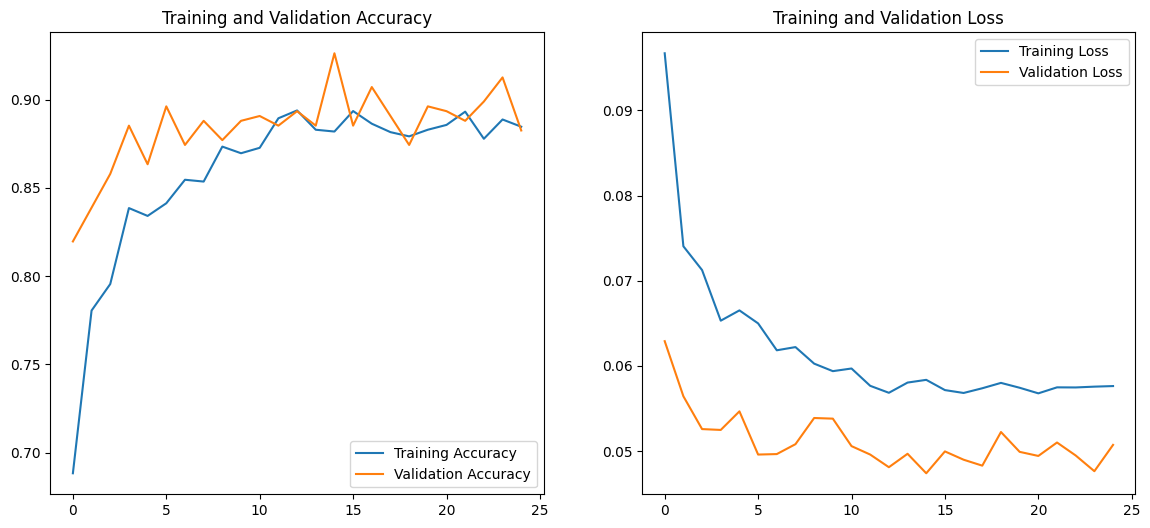

In [26]:
# --------------------- 25. Plot Training History ---------------------
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

In [27]:
# --------------------- 26. Grad-CAM Functions ---------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1, if possible
    if tf.math.reduce_max(heatmap) != 0:
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    else:
        heatmap = tf.zeros_like(heatmap)  # Set heatmap to zero if normalization fails

    # Convert heatmap to float32 for compatibility with OpenCV
    heatmap = tf.cast(heatmap, dtype=tf.float32)

    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="gradcam.jpg", alpha=0.4):
    """
    Superimposes the Grad-CAM heatmap on the original image and saves/displays it.
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image from path: {img_path}")

    img = cv2.resize(img, IMAGE_SIZE)

    # Resize and apply heatmap overlay
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * alpha + img
    cv2.imwrite(cam_path, superimposed_img)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()

# Identify the last convolutional layer in the base model
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No convolutional layer found in the model.")

print(f"Last convolutional layer for Grad-CAM: {last_conv_layer_name}")

Last convolutional layer for Grad-CAM: conv2d_1


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


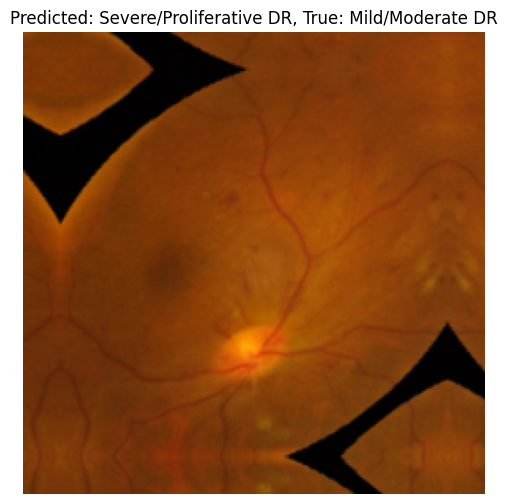

Fuzzy Membership Probabilities:
No DR: 0.0391
Mild/Moderate DR: 0.4207
Severe/Proliferative DR: 0.5400


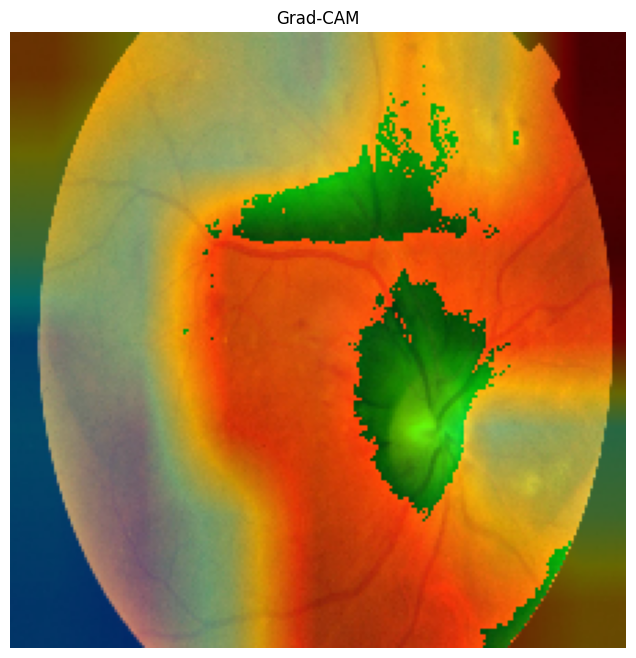

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Attention Map Shape (after squeeze): (7, 7)
Attention Map Data Type: float16


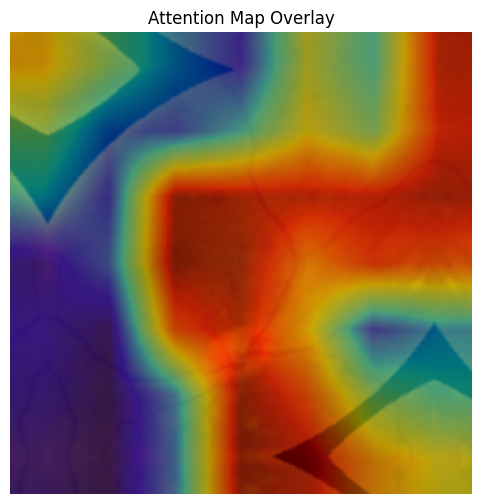

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


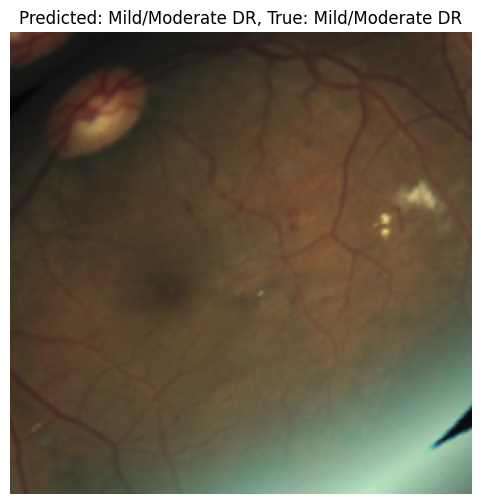

Fuzzy Membership Probabilities:
No DR: 0.0450
Mild/Moderate DR: 0.7983
Severe/Proliferative DR: 0.1571


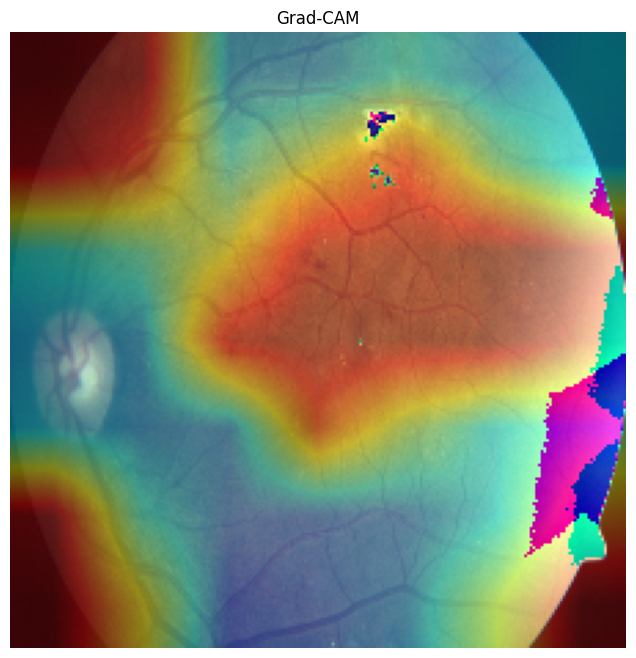

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Attention Map Shape (after squeeze): (7, 7)
Attention Map Data Type: float16


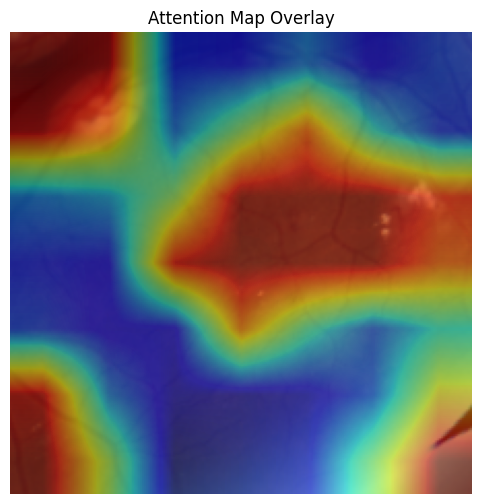

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


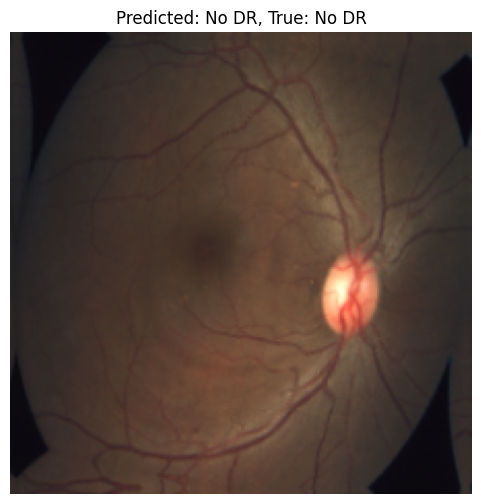

Fuzzy Membership Probabilities:
No DR: 0.8340
Mild/Moderate DR: 0.1129
Severe/Proliferative DR: 0.0533


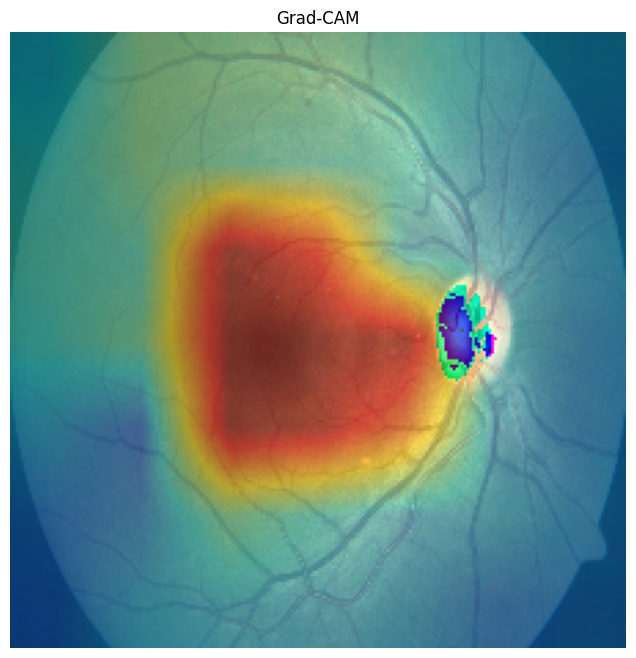

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Attention Map Shape (after squeeze): (7, 7)
Attention Map Data Type: float16


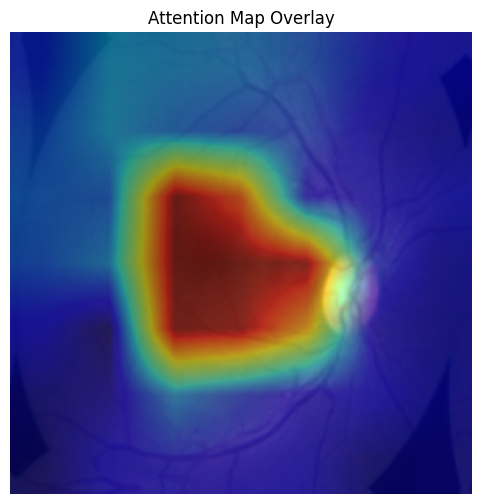

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


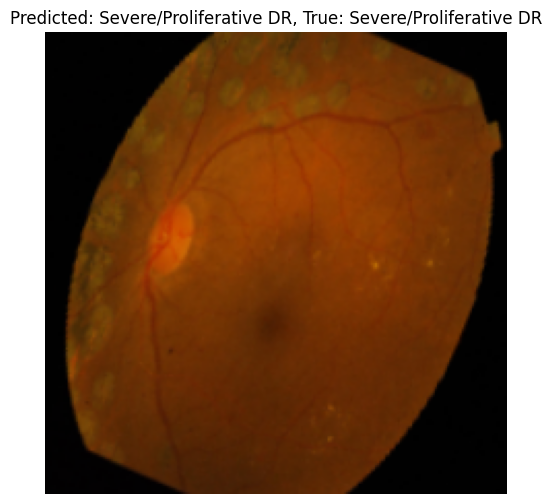

Fuzzy Membership Probabilities:
No DR: 0.0571
Mild/Moderate DR: 0.1552
Severe/Proliferative DR: 0.7876


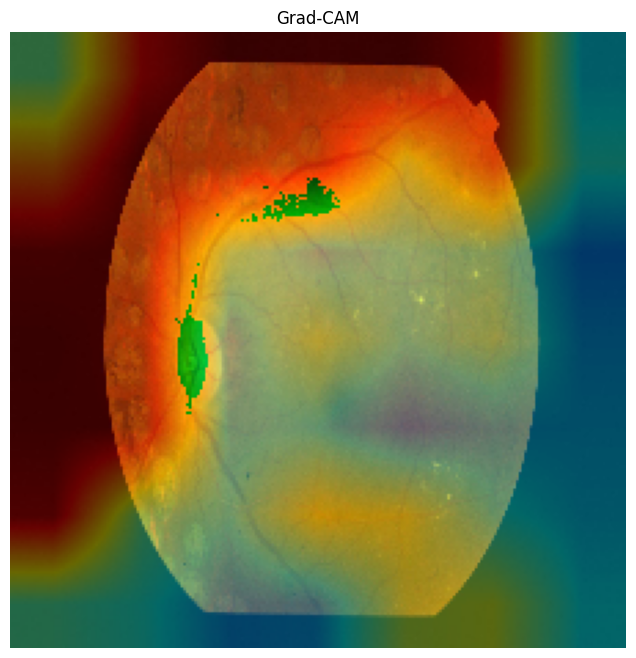

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Attention Map Shape (after squeeze): (7, 7)
Attention Map Data Type: float16


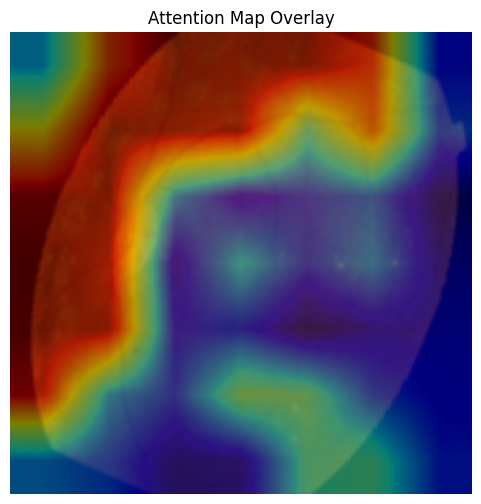

In [28]:

# --------------------- 27. Prediction Function with Integrated Explainability ---------------------
def predict_with_explainability(image_path, model, attention_model, last_conv_layer_name, test_df):
    # Preprocess the image
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_raw, channels=3)
    image_resized = tf.image.resize(image, IMAGE_SIZE)
    image_aug = data_augmentation(image_resized)
    image_preprocessed = tf.keras.applications.efficientnet_v2.preprocess_input(image_aug)
    image_preprocessed = tf.cast(image_preprocessed, dtype=tf.float32)
    image_array = tf.expand_dims(image_preprocessed, axis=0)

    # Predict
    preds = model.predict(image_array)
    classes = ['No DR', 'Mild/Moderate DR', 'Severe/Proliferative DR']
    pred_class = np.argmax(preds, axis=1)[0]
    probabilities = preds[0]

    # Get True Label
    filename = os.path.basename(image_path)
    id_code = os.path.splitext(filename)[0]
    true_label_row = test_df[test_df['id_code'] == id_code]
    if not true_label_row.empty:
        true_label = true_label_row['diagnosis'].values[0]
        true_label_name = classes[int(true_label)]
    else:
        true_label_name = 'Unknown'

    # Display Image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_aug.numpy().astype("uint8"))
    plt.title(f"Predicted: {classes[pred_class]}, True: {true_label_name}")
    plt.axis('off')
    plt.show()

    # Print Membership Probabilities
    print("Fuzzy Membership Probabilities:")
    for cls, prob in zip(classes, probabilities):
        print(f"{cls}: {prob:.4f}")

    # Generate Grad-CAM Heatmap
    heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name, pred_index=pred_class)
    save_and_display_gradcam(image_path, heatmap, cam_path="gradcam.jpg", alpha=0.4)

    # Generate Attention Map from Attention Model
    attention_scores = attention_model.predict(image_array)
    attention_map = attention_scores[0]
    attention_map = np.squeeze(attention_map)  # Ensure 2D format for OpenCV

    # Print attention map details for debugging
    print("Attention Map Shape (after squeeze):", attention_map.shape)
    print("Attention Map Data Type:", attention_map.dtype)

    # Check for valid range and normalize attention map to [0,1]
    if np.max(attention_map) != np.min(attention_map):  # Avoid division by zero
        attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))
    else:
        attention_map = np.zeros_like(attention_map)  # Set to zero if normalization fails

    # Convert to float32 if necessary and check dimensions
    attention_map = np.array(attention_map, dtype=np.float32)
    
    # Check if attention map is 2D before resizing
    if len(attention_map.shape) == 2:
        attention_map_resized = cv2.resize(attention_map, IMAGE_SIZE)
        
        # Display attention overlay
        plt.figure(figsize=(6, 6))
        plt.imshow(image_aug.numpy().astype("uint8"))
        plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title('Attention Map Overlay')
        plt.show()
    else:
        print("Error: Attention map is not 2D, skipping resize and overlay display.")

# --------------------- 28. Example Predictions with Integrated Explainability ---------------------
sample_image_paths = [
    '/kaggle/input/aptos2019/test_images/test_images/e756495c11cb.png',
    '/kaggle/input/aptos2019/test_images/test_images/e580676516b0.png',
    '/kaggle/input/aptos2019/test_images/test_images/e68bdd36e589.png',
    '/kaggle/input/aptos2019/test_images/test_images/e4f12411fd85.png'
]

for img_path in sample_image_paths:
   predict_with_explainability(img_path, model, attention_model, last_conv_layer_name,test_df)